In [19]:
import numpy as np

import pandas as pd
%pylab inline
from pylab import rcParams
from pandas import DataFrame
#import seaborn; seaborn.set()
rcParams['figure.figsize'] = 16,8
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import ward_tree
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from fastdtw import fastdtw
from operator import itemgetter
from scipy.stats import itemfreq
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import kurtosis, skew


Populating the interactive namespace from numpy and matplotlib


## Dataset: IBM stock values from 1962 to 2018

In [2]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep='\t',header=0)

In [84]:
series.describe()

count    14168.000000
mean        57.438904
std         56.427873
min          4.080000
25%         15.967187
50%         27.843750
75%         93.757500
max        215.380005
Name: Open, dtype: float64

### Line Plot

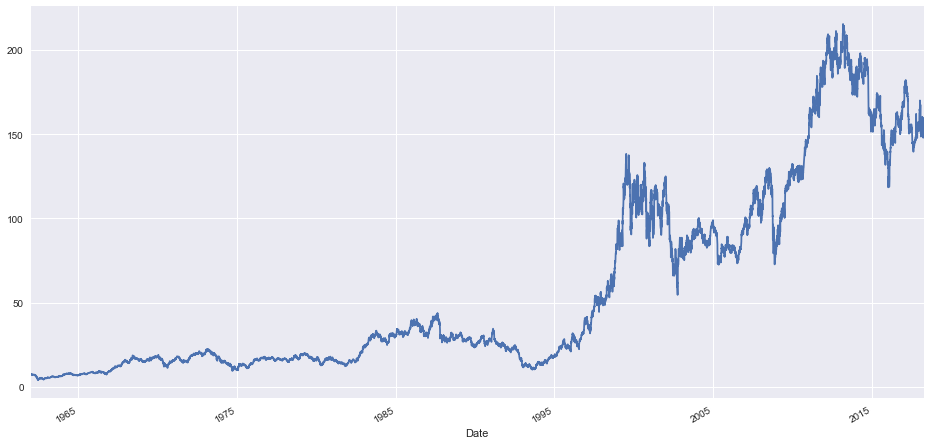

In [85]:
series.plot()

### Histogram

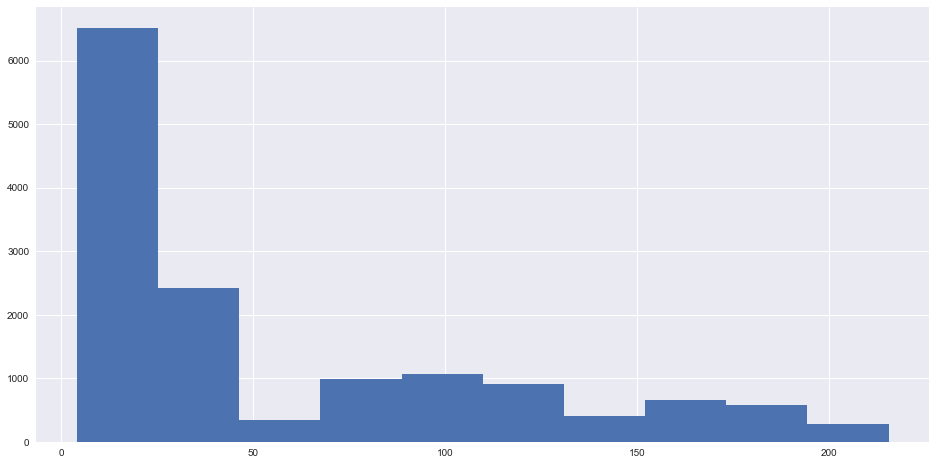

In [87]:
series.hist()
pyplot.show()

### Density Plot

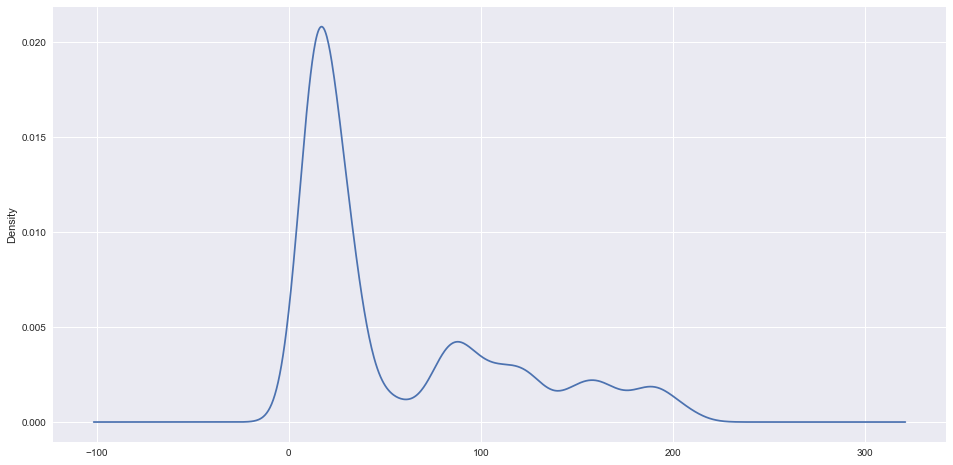

In [88]:
series.plot(kind='kde')
pyplot.show()

### Lag Scatter Plot

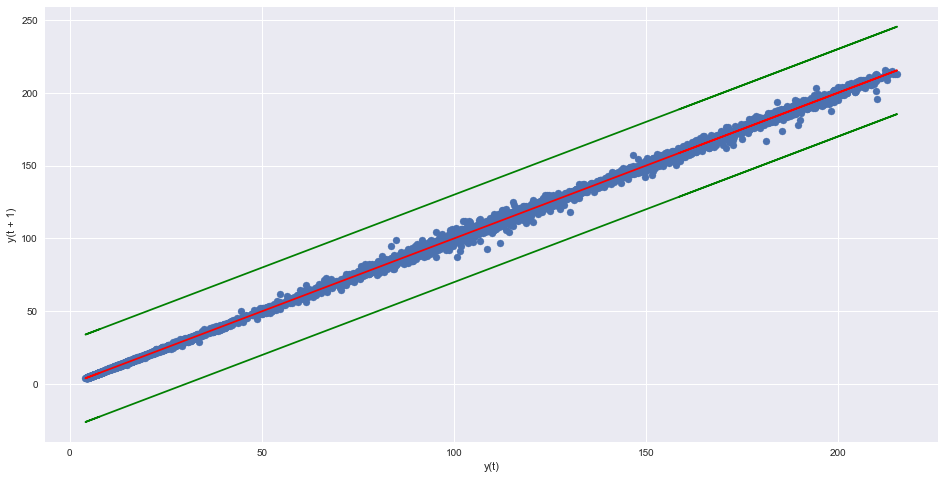

In [89]:
from pandas.plotting import lag_plot

lag_plot(series)
plot(series, series, 'r-')
plot(series, series+30, 'g-')
plot(series, series-30, 'g-')
pyplot.show()

### Lag Scatter Plot (week)

### Autocorrelation

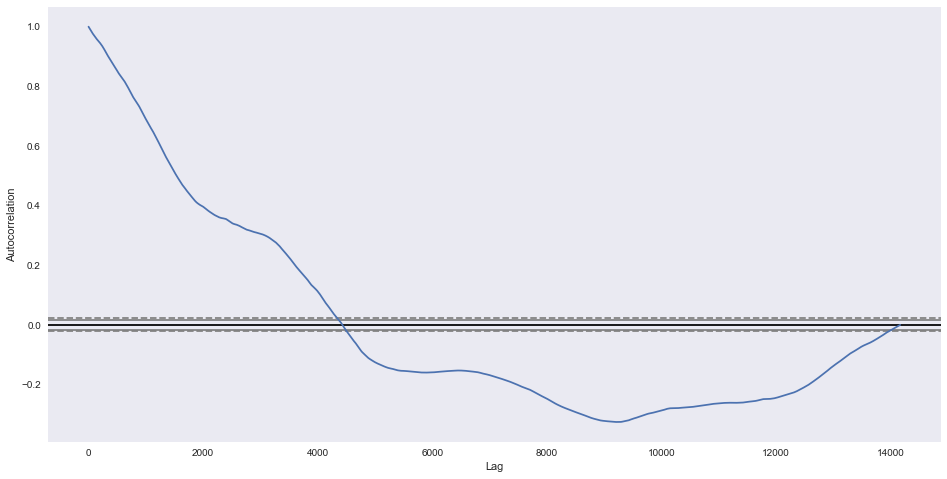

In [90]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
axis('auto')
pyplot.show()

### Yearly Line Plot

In [3]:
series = series["1962-01-02":"2017-12-29"] # Rimuovo il 2018

In [4]:
groups = series.groupby(pd.Grouper(freq='A'))
years = []
yearly_series = []
yearly_list = []
for name, group in groups:
    years.append(name.year) # Lista contenente gli anni
    yearly_series.append(pd.Series(group)) # Lista contenente serie pandas per ogni anno
    yearly_list.append(list(group.values)) # Lista contenente liste per ogni anno

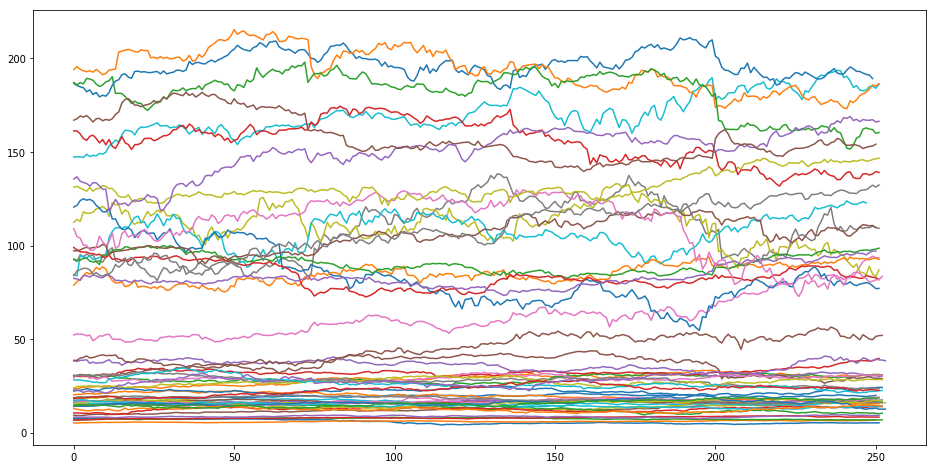

In [115]:
for i in range(len(yearly_list)):
    plt.plot(yearly_list[i])

### Yearly Boxplot

{'boxes': [<matplotlib.lines.Line2D at 0x1a228181d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a22818da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a2282aba8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a2282a710>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a22818390>,
  <matplotlib.lines.Line2D at 0x1a22bfb8d0>]}

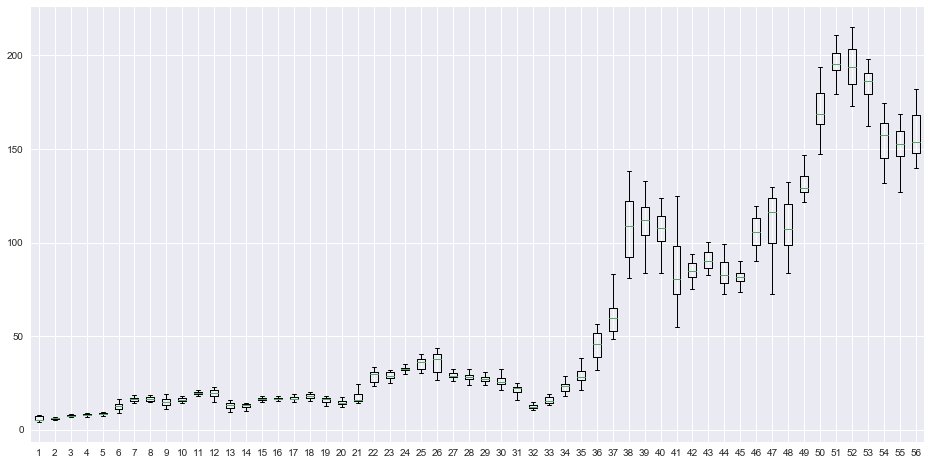

In [124]:
plt.boxplot(yearly_list)

### Yearly Heatmap

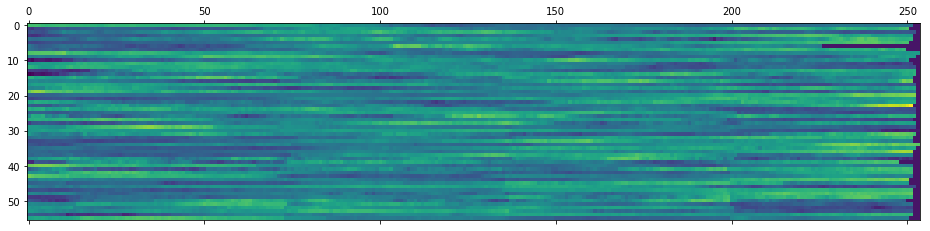

In [5]:
groups = series.groupby(pd.Grouper(freq='A'))
mm = DataFrame()
for name, group in groups:
    norm_values = (group.values - mean(group.values)) / std(group.values)
    # Padding performed to have series of same length -- important only for plotting the matrix
    pad_values = np.pad(norm_values,(0,254-len(norm_values)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
matshow(mm.T, interpolation=None, aspect='auto')

### Yearly Transformations

### Transformation II: Normalization

In [6]:
groups = series.groupby(pd.Grouper(freq='A'))
yearly_list_norm = []
for name, group in groups:
    group_values = list(group.values)
    scaling_values = (group_values - mean(group_values))/std(group_values)
    yearly_list_norm.append(scaling_values)

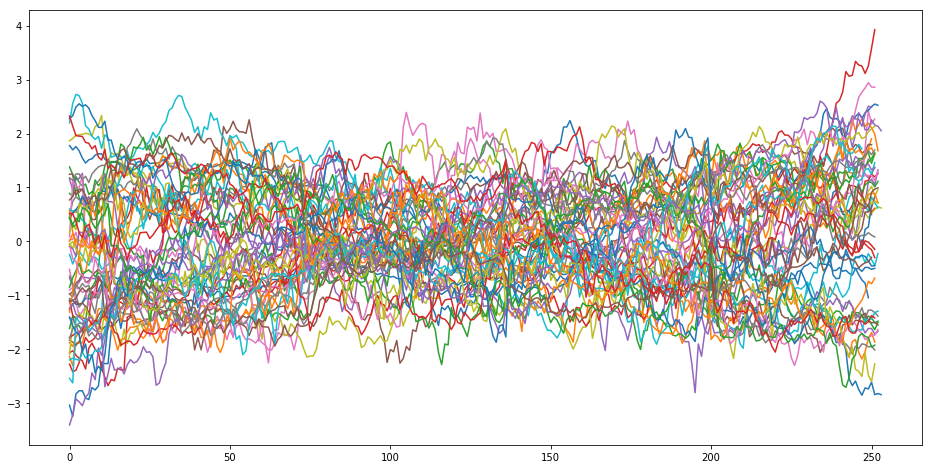

In [7]:
for i in range(len(yearly_list_norm)):
    plt.plot(yearly_list_norm[i])

#### Boxplot dati normalizzati

{'boxes': [<matplotlib.lines.Line2D at 0x1a1859df60>,
 'caps': [<matplotlib.lines.Line2D at 0x1a17a50a20>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a17a57780>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a17a57320>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a17a500f0>,
  <matplotlib.lines.Line2D at 0x1a18ae7048>]}

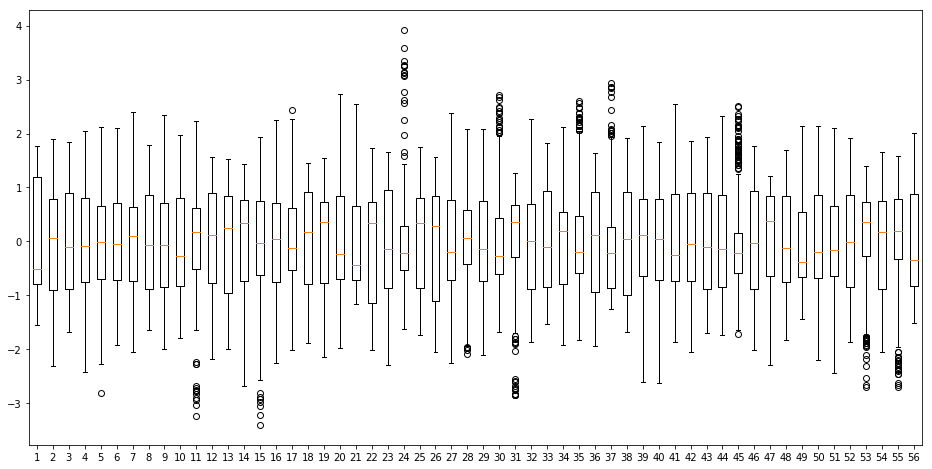

In [18]:
plt.boxplot(yearly_list_norm)

### Transformation IV: Noise (smoothing)

In [7]:
groups = series.groupby(pd.Grouper(freq='A'))
yearly_list_smooth = []
for name, group in groups:
    group_values = list(group.values)
    scaling_values = (group_values - mean(group_values))/std(group_values)
    scaling_series = pd.Series(scaling_values) #trasformo in serie per calcolare la rolling mean
    shift_series = scaling_series.rolling(window=12).mean()
    yearly_list_smooth.append(list(shift_series))

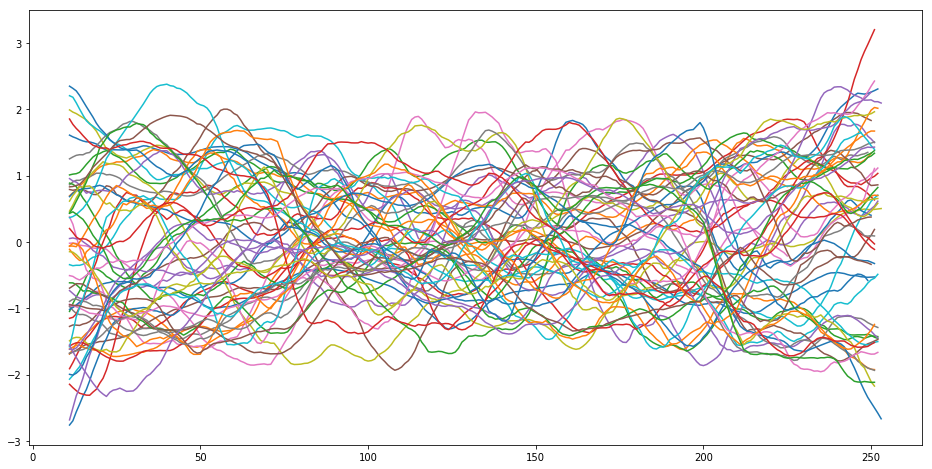

In [8]:
for i in range(len(yearly_list_smooth)):
    plt.plot(yearly_list_smooth[i])

In [9]:
yearly_series_smooth = []
for i in range(len(yearly_list_smooth)):
    yearly_series_smooth.append(pd.Series(yearly_list_smooth[i]))
    yearly_series_smooth[i] = pd.Series.dropna(yearly_series_smooth[i])

## DTW

In [104]:
def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [105]:
def distance(x,y):
    return abs(x-y)

#### Algoritmo Prof.

In [44]:
%%time
# CAUTION !!! CAN BE VERY SLOW !!!
#month_list = mm_small.keys()
# Compute upper half of matrix
dd1 = [ [ (dtw(list(yearly_series_smooth[x]),list(yearly_series_smooth[y]),distance)[0] \
           if y > x else -1)  \
         for y in range(len(years)) ] 
       for x in range(len(years)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years)) ] for x in range(len(years)) ]
# Finally, the diagonal
for i in range(len(years)):
    dd2[i][i] = 0.0

CPU times: user 2min 7s, sys: 811 ms, total: 2min 8s
Wall time: 2min 11s


#### Algoritmo FastDTW

In [20]:
%%time
# CAUTION !!! CAN BE VERY SLOW !!!
#month_list = mm_small.keys()
# Compute upper half of matrix
dd1 = [ [ (fastdtw(list(yearly_series_smooth[x]), list(yearly_series_smooth[y]), dist=cityblock)[0] \
           if y > x else -1)  \
         for y in range(len(years)) ] 
       for x in range(len(years)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years)) ] for x in range(len(years)) ]
# Finally, the diagonal
for i in range(len(years)):
    dd2[i][i] = 0.0

CPU times: user 1min 27s, sys: 268 ms, total: 1min 27s
Wall time: 1min 28s


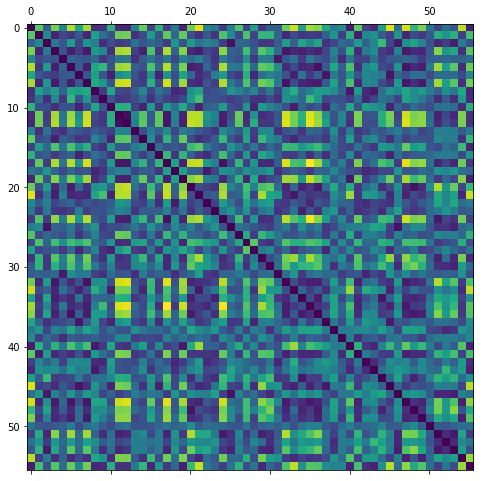

In [21]:
matshow(dd2, interpolation=None, aspect='auto')

In [24]:
# Esporto la matrice in csv per non doverla ricalcolare ogni volta

import csv

with open("dd1_smooth_dtw.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(dd1)
    
with open("dd2_smooth_dtw.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(dd2)

## CDM

In [26]:
def CDM(x,y):
    import zlib
    return float(len(zlib.compress(x + y))) / float(len(zlib.compress(x)) + len(zlib.compress(y)))

In [36]:
%%time
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

# Compute upper half of matrix
dd1 = [ [ (CDM((''.join(array(pd.cut(list(yearly_series_smooth[x]),len(alphabet),labels=alphabet)))).encode(),(''.join(array(pd.cut(list(yearly_series_smooth[y]),len(alphabet),labels=alphabet)))).encode()) \
           if y > x else -1)  \
         for y in range(len(years)) ] 
       for x in range(len(years)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years)) ] for x in range(len(years)) ]
# Finally, the diagonal
for i in range(len(years)):
    dd2[i][i] = 0.0

# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years)) ] for x in range(len(years)) ]
# Finally, the diagonal
for i in range(len(years)):
    dd2[i][i] = 0.0

CPU times: user 2.61 s, sys: 15.3 ms, total: 2.62 s
Wall time: 2.76 s


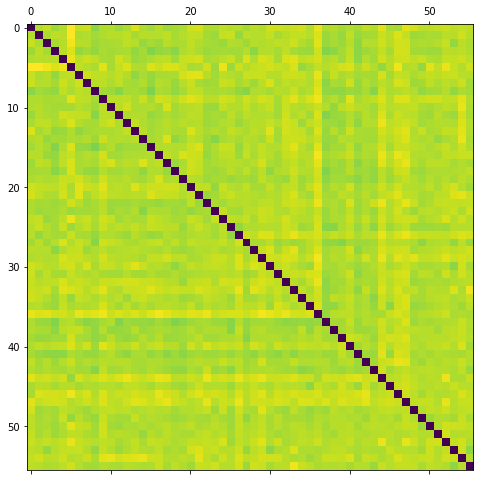

In [37]:
matshow(dd2, interpolation=None, aspect='auto')

In [38]:
# Esporto la matrice in csv per non doverla ricalcolare ogni volta

import csv

with open("dd1_smooth_cdm.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(dd1)
    
with open("dd2_smooth_cdm.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(dd2)

## Structural Distances

In [29]:
feat = []
for i in range(len(yearly_series_smooth)):
    feat.append([mean(np.array(yearly_series_smooth[i])), 
                 std(np.array(yearly_series_smooth[i])), 
                 kurtosis(np.array(yearly_series_smooth[i])),
                 mean(np.array(yearly_series_smooth[i])[1:]-np.array(yearly_series_smooth[i])[:-1]),
                 skew(np.array(yearly_series_smooth[i])[1:]-np.array(yearly_series_smooth[i])[:-1]),
                 kurtosis(np.array(yearly_series_smooth[i])[1:]-np.array(yearly_series_smooth[i])[:-1])])

In [31]:
norm_feat = transpose([ (attr-mean(attr))/std(attr)  for attr in transpose(feat) ])

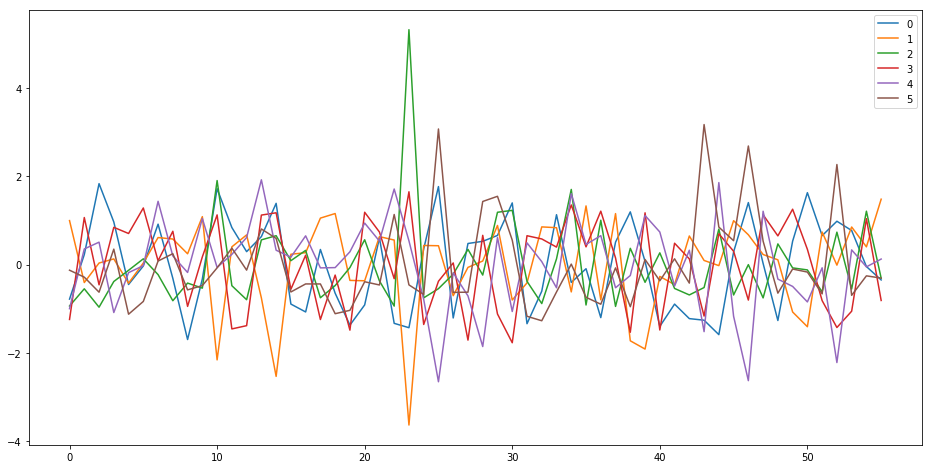

In [33]:
plot(norm_feat)
legend(range(len(feat[0])))

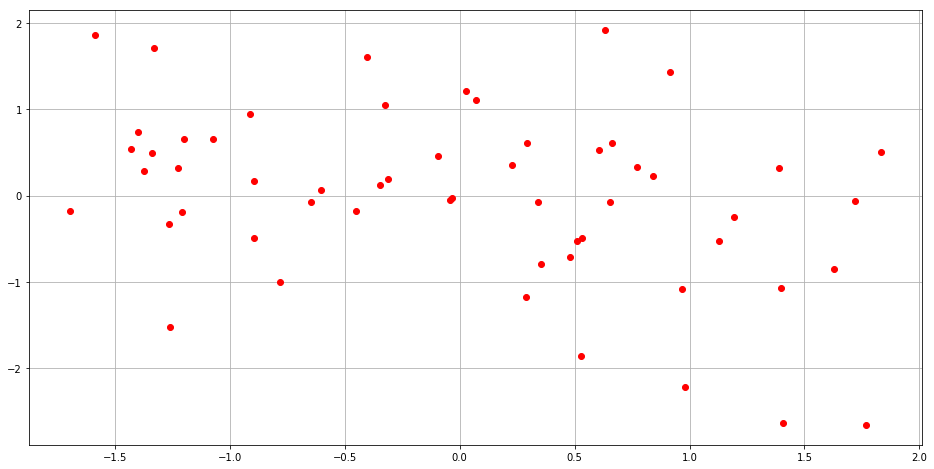

In [34]:
plot(transpose(norm_feat)[0], transpose(norm_feat)[4],'or')
grid(True)

In [36]:
# Esporto la matrice in csv per non doverla ricalcolare ogni volta

import csv

with open("norm_feat.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(norm_feat)